## Importing libs and loading the dataset

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = [6, 6]
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

## 0. Computational Graph definition and implementation

We will define a Computational Graph [[ref]](https://colah.github.io/posts/2015-08-Backprop/) where each node either represents a value (i.e. what will later be a **layer** in a neural network) or a computation (i.e. an operation like the **activation** or **cost** functions in a neural network).

With it we can then represent both an artificial neural network, aswell as a softmax regressor (which performs Multinomial Logistic Regression).

In [3]:
import warnings
from time import time

RANDOM_SEED = 886

In [4]:
np.random.seed(RANDOM_SEED)

In [5]:
class ActivationFunction:
    ''' An ActivationFunction is applied to Z to get the output A, 
        but its derivative expects the value A, not Z (!):

        A == __call__(Z) and derivative(A) == derivative(__call__(Z)), 
        calling derivative(Z) will often yield WRONG results
    '''
    def __call__(self, Z):
        ''' Z.shape=(n_examples, layer_output_size) '''
        raise NotImplementedError    
    def derivative(self, A):
        ''' A.shape=(n_examples, layer_output_size) '''
        raise NotImplementedError

class Sigmoid(ActivationFunction):
    def __call__(self, Z, clip=500):
        Z = np.clip(Z, -clip, clip) # numerical stability
        return 1 / (1 + np.exp(-Z))
    def derivative(self, A):
        return A * (1 - A) # Sigmoid(Z) * (1 - Sigmoid(Z))

class ReLU(ActivationFunction):
    def __call__(self, Z):
        return np.maximum(0, Z)
    def derivative(self, A):
        return np.where(A > 0, 1, 0)

class SoftMax(ActivationFunction):
    def __call__(self, Z):
        exp = np.exp(Z - Z.max(axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)
    def derivative(self, A, eps=1e-9):
        Ypred = A+eps
        return Ypred * (1 - Ypred) # SoftMax(Z) * (1 - SoftMax(Z))

In [6]:
class CostFunction:
    ''' A CostFunction is applied to Y (the target values) and Ypred (the predicted values) to get a scalar output
        Its derivative w.r.t. Ypred also expects Y and Ypred, but returns a tensor of shape (n_examples, last_layer_output_size)
        
        obs.: Ypred is the last layer's activation values: last_layer.A == last_layer.g(last.layer.Z), 
              i.e. last_layer is the output layer of the network
    '''
    def __call__(self, Y, Ypred):
        ''' Y.shape == Ypred.shape == (n_examples, last_layer_output_size) '''
        raise NotImplementedError # [J(Y, Ypred) == J(Y, A^L)]
    def derivative(self, Y, Ypred):
        ''' Y.shape == Ypred.shape == (n_examples, last_layer_output_size) '''
        raise NotImplementedError # [dJ/dYpred == dJ/dA^L]
    def deltaL(self, Y, Ypred, activation_function):
        ''' Y.shape == Ypred.shape == (n_examples, last_layer_output_size) 

            activation_function should be the last layer's g function, thus Ypred == activation_function(Z)
            and the value returned is the delta for the output layer of the network (delta^L == dJ/dZ^L)
        '''
        return self.derivative(Y, Ypred) * activation_function.derivative(A=Ypred) # [dJ/dZ^L == dJ/dYpred . dYpred/dZ^L]
        # obs.: Ypred == A^L == g(Z^L), thus dYpred/dZ^L == dA^L/dZ^L == g'(Z^L)
        #       [dJ/dZ^L == dJ/dYpred . dYpred/dZ^L == dJ/dA^L . dA^L/dZ^L]

class CrossEntropy(CostFunction):
    def __call__(self, Y, Ypred, eps=1e-9):
        return np.mean( -(Y * np.log(Ypred+eps)).sum(axis=1) )
    def derivative(self, Y, Ypred, eps=1e-9):
        m = Ypred.shape[0]
        return - (Y / (Ypred+eps)) / m
    def deltaL(self, Y, Ypred, activation_function):
        if isinstance(activation_function, SoftMax):
            m = Ypred.shape[0]
            # numerically stable
            return (Ypred - Y) / m # (SoftMax(Z) - Y) / m
        else:
            return super().deltaL(Y, Ypred, activation_function)

In [7]:
class Optimizer:
    ''' The optimizer's optimization policy should be implemented on its update(layers) function '''
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    def update(self, layers):
        ''' Updates the parameters (i.e. weights and biases) for each layer in the layers list '''
        raise NotImplementedError
    def init(self, layers):
        ''' Performs initializations that require knowledge about the layers list '''
        pass

class GradientDescent(Optimizer):
    def __init__(self, learning_rate):
        super().__init__(learning_rate)
    def update(self, layers):
        for layer in layers[1:]:
            layer.W -= self.learning_rate * layer.dW
            layer.b -= self.learning_rate * layer.db

class Momentum(Optimizer):
    def __init__(self, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.last_dW = None # stores the last value of dW for each layer
        self.last_db = None # stores the last value of db for each layer
    def update(self, layers):
        for l in range(1, len(layers)):
            layer = layers[l]
            self.last_dW[l] = (self.momentum * self.last_dW[l]) + (self.learning_rate * layer.dW)
            self.last_db[l] = (self.momentum * self.last_db[l]) + (self.learning_rate * layer.db)
            layer.W -= self.last_dW[l]
            layer.b -= self.last_db[l]
    def init(self, layers):
        self.last_dW = [0 for _ in len(layers)]
        self.last_db = [0 for _ in len(layers)]

In [8]:
class Layer:
    ''' A.shape == (n_examples, output_size)
        Z.shape == (n_examples, output_size)
        W.shape == (input_size, output_size)
        b.shape == (output_size, )
        X.shape == (n_examples, input_size)
        obs.:
            input_size == prev_layer.output_size
            output_size == next_layer.input_size
    '''
    def __init__(self, output_size, activation_function, name=""):
        if activation_function != None:
            # obs.: the activation_function should only be None for the network's input layer
            assert(isinstance(activation_function, ActivationFunction)), "Invalid object type for activation_function"
        
        self.name = name
        
        self.input_size = None
        self.output_size = output_size
        
        # activation function
        self.g = activation_function # g_prime == activation_function.derivative
        
        # activation values
        self.A = None # self.A == self.g(self.Z)
        self.Z = None # prev_layer.A @ self.W + self.b
        
        # output value of the previous layer
        self.X = None # == prev_layer.A
        self.dX = None
        
        # parameters (weights and biases)
        self.W = None
        self.b = None
        self.dW = None
        self.db = None
    
    def init(self, input_size, weight_initialization):
        ''' Sets the layer's input_size and initializes its weights and biases '''
        self.input_size = input_size
        if weight_initialization == 'xavier':
            stddev = np.sqrt(1 / self.input_size)
            self.W = stddev * np.random.randn(self.input_size, self.output_size)
            self.b = np.random.randn(self.output_size, )
        elif weight_initialization == 'xavier_avg':
            stddev = np.sqrt(2 / (self.input_size + self.output_size))
            self.W = stddev * np.random.randn(self.input_size, self.output_size)
            self.b = np.random.randn(self.output_size, )
        elif weight_initialization == 'rand_-1_to_1':
            self.W = 2 * np.random.randn(self.input_size, self.output_size) - 1
            self.b = 2 * np.random.randn(self.output_size, ) - 1
        else:
            raise ValueError(f"Invalid weight_initialization value: '{weight_initialization}'")
    
    @property
    def params_count(self):
        count = 0
        if self.W is not None:
            count += self.W.size
        if self.b is not None:
            count += self.b.size
        return count
    
    # receives the activation values of the previous layer (i.e. this layer's input)
    # returns the activation values of the current layer (i.e. next layer's input)
    def feedforward(self, X):
        ''' X.shape == (n_examples, self.input_size) '''
        assert(X.shape[1] == self.input_size)
        self.X = X
        # (n_examples, output_size) = (n_examples, input_size) @ (input_size, output_size) + (output_size, )
        self.Z = self.X @ self.W + self.b
        self.A = self.g(self.Z)
        return self.A
    
    # receives the derivative of the cost function w.r.t. the Z value of the current layer [dJ/dZ = dJ/dA . dA/dZ]
    # returns the derivative of the cost function w.r.t. the A value of the previous layer [dJ/dX = dJ/dZ . dZ/dX]
    # obs.: the A value of the previous layer is this layer's input value X
    def backprop(self, dZ):
        ''' dZ.shape == (n_examples, self.output_size)
        
            Note that only calling backprop doesn't actually update the layer parameters
        '''
        assert(dZ.shape[1] == self.output_size)
        # (input_size, output_size) = (input_size, n_examples)  @ (n_examples, output_size)
        # (output_size, )           = (n_examples, output_size).sum(axis=0)
        # (n_examples, input_size)  = (n_examples, output_size) @ (output_size, input_size), input_size==prev_layer.output_size
        self.dW = (self.X).T @ dZ              # [dJ/dW = dJ/dZ . dZ/dX]
        self.db = dZ.sum(axis=0)               # [dJ/db = dJ/dZ . dZ/db]
        self.dX = dZ @ (self.W).T              # [dJ/dX = dJ/dZ . dZ/dX]
        return self.dX
        # note that dJ/dX is dJ/dA for the previous layer (since this layer's input X is the previous layer's A)

In [9]:
class ComputationalGraph:
    def __init__(self, layers, cost_function, optimizer, weight_initialization='xavier', name=""):
        assert(isinstance(cost_function, CostFunction)), "Invalid object type for cost_function"
        
        self.name = name
        
        self.J = cost_function # cost_function(Y, Ypred)
        # obs.: cost_function.derivative is the derivative of J w.r.t. the last layer's activation values [dJ/dYpred]
        #       Ypred == self.layers[-1].A, thus [dJ/dYpred == dJ/dA^L]
        #
        #       cost_function.deltaL is the derivative of J w.r.t. the last layer's Z values [dJ/dZ^L]
        #       Z^L == self.layers[-1].Z, thus [dJ/dZ^L == dJ/dA^L . dA^L/dZ^L == dJ/dYpred . dYpred/dZ^L]
        
        self.optimizer = optimizer # obs.: the learning rate is set on the optimizer object
        
        self.layers = []
        # obs.: we don't call init for the input layer since we set it's activation values manually
        layers[0].input_size = layers[0].output_size
        self.layers.append(layers[0]) # input layer
        for l in range(1, len(layers)):            
            # sets the layer's input_size as the last layer's output_size and initializes its weights and biases
            layers[l].init(input_size=layers[l-1].output_size, weight_initialization=weight_initialization)            
            self.layers.append(layers[l]) # adds the initialized layer to the network
        
        self.optimizer.init(self.layers) # performs initializations that require knowledge about the layers list
        
        self.history = { "loss": [], "loss_val": [], "acc": [], "acc_val": [], "lr": self.optimizer.learning_rate }
    
    def __str__(self):
        to_str = self.name + "\n"
        to_str += "[name?] Layer (input_size, output_size) params_count\n"
        to_str += "----------------------------------------------------\n"
        for l in range(len(self.layers)):
            layer = self.layers[l]
            to_str += f"{'' if layer.name == '' else '['+layer.name+'] '}Layer_{l} "
            to_str += f"({layer.input_size}, {layer.output_size}) {layer.params_count}\n"
        return to_str
    
    # note that we use zero-based indexing here, so
    # the 1st layer is self.layers[0] and the last is self.layers[len(self.layers) - 1]
    
    def predict(self, X):
        ''' X.shape == (n_examples, self.layers[0].input_size) '''
        assert(X.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        activation = X # network's input
        for l in range(1, len(self.layers)):
            Z = activation @ self.layers[l].W + self.layers[l].b
            activation = self.layers[l].g(Z)
        return activation # network's output (Ypred)
    
    def feedforward(self, X):
        ''' X.shape     == (n_examples, self.layers[0].input_size) '''
        assert(X.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        self.layers[0].A = X # input
        for l in range(1, len(self.layers)):
            self.layers[l].feedforward(self.layers[l-1].A)
        Ypred = self.layers[-1].A # output
        return Ypred
    
    def backprop(self, X, Y, Ypred):
        ''' X.shape     == (n_examples, self.layers[0].input_size)
            Y.shape     == (n_examples, self.layers[-1].output_size)
            Ypred.shape == (n_examples, self.layers[-1].output_size)
            where Ypred is the result of feedforward(X)
            
            Note that only calling backprop doesn't actually update the network parameters
        '''
        assert(X.shape[0] == Y.shape[0])
        assert(X.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        assert(Y.shape[1] == self.layers[-1].output_size)
        assert(Ypred.shape == Y.shape)
        
        delta = self.J.deltaL(Y, Ypred, self.layers[-1].g) # delta^L == [dJ/dZ^L]
        self.layers[-1].backprop(dZ=delta)
        for l in reversed(range(1, len(self.layers) - 1)):
            # [dJ/dZ^l == dJ/dA^l . dA^l/dZ^l], note that dJ/dA^l is dJ/dX^{l+1}
            delta = self.layers[l+1].dX * self.layers[l].g.derivative(self.layers[l].A) # delta^l == [dJ/dZ^l]
            self.layers[l].backprop(dZ=delta)
        
        # obs.: we don't backpropagate the input layer since we 
        #       manually set it's activation values A to the network's input X
    
    def __shuffle_X_Y(self, X, Y):
        m = X.shape[0] # == Y.shape[0]
        p = np.random.permutation(m)
        return X[p], Y[p]
    
    def __get_batches(self, X, Y, batch_size, shuffled):
        m = X.shape[0] # == Y.shape[0]
        n_batches = m // batch_size
        if shuffled:
            X, Y = self.__shuffle_X_Y(X, Y)
        return zip(np.array_split(X, n_batches), np.array_split(Y, n_batches))
    
    # test data
    def evaluate(self, X_test, Y_test):
        ''' X_test.shape == (n_test_samples, self.layers[0].input_size)
            Y_test.shape == (n_test_samples, self.layers[-1].output_size)
        '''
        assert(X_test.shape[0] == Y_test.shape[0])
        assert(X_test.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        assert(Y_test.shape[1] == self.layers[-1].output_size)
        
        # loss/cost value for the training set
        Ypred = self.predict(X_test) # same as self.feedforward(X_test) but doesn't change the 'cached' values
        cost = self.J(Y_test, Ypred)
        
        # calculates the values not as one-hot encoded row vectors
        target = np.argmax(Y_test, axis=1)
        prediction = np.argmax(Ypred, axis=1)
        accuracy = (prediction == target).mean()

        return cost, accuracy
    
    # training and validation data
    def train(self, X, Y, X_val, Y_val, n_epochs, batch_size, verbose=True):
        ''' X.shape == (n_training_samples, self.layers[0].input_size)
            Y.shape == (n_training_samples, self.layers[-1].output_size)
            
            X_val.shape == (n_validation_samples, self.layers[0].input_size)
            Y_val.shape == (n_validation_samples, self.layers[-1].output_size)
            
            For each iteration we'll have:
              n_examples = batch_size
              batch_X.shape == (n_examples, self.layers[0].input_size)
              batch_Y.shape == (n_examples, self.layers[-1].output_size)
            Thus, each epoch has ceil(n_training_samples / batch_size) iterations
            obs.: batch_X and batch_Y are rows of X and Y, and after each iteration (i.e. after going through
                  each batch) we update our network parameters (weights and biases)
            
            If n_training_samples is not divisible by batch_size the last training batch will be smaller
        '''
        assert(X.shape[0] == Y.shape[0])
        assert(X.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        assert(Y.shape[1] == self.layers[-1].output_size)
        assert(X_val.shape[0] == Y_val.shape[0])
        assert(X_val.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        assert(Y_val.shape[1] == self.layers[-1].output_size)
        
        n_training_samples = X.shape[0]
        batches_per_epoch = int(np.ceil(n_training_samples / batch_size)) # equal to the number of iterations per epoch
        
        if verbose:
            self.history = { "loss": [], "loss_val": [], "acc": [], "acc_val": [], "lr": self.optimizer.learning_rate }
        
        for epoch in range(n_epochs):
            if verbose:
                start_time = time()
                batch_number = 1
                
            for batch_X, batch_Y in self.__get_batches(X, Y, batch_size, shuffled=True):
                # calculates the predicted target values for this batch (with the current network parameters)
                batch_Ypred = self.feedforward(batch_X)
                
                # sets the values of dW and db, used to then update the network parameters
                self.backprop(batch_X, batch_Y, batch_Ypred)
                
                # updates each layer's parameters (i.e. weights and biases) with some flavor of gradient descent
                self.optimizer.update(self.layers)
                
                if verbose:
                    print(f"batch ({batch_number}/{batches_per_epoch})", end='\r')
                    batch_number += 1
            
            # calculate the loss/cost value for this epoch
            epoch_cost, epoch_accuracy = self.evaluate(X, Y) # training set
            epoch_cost_val, epoch_accuracy_val = self.evaluate(X_val, Y_val) # validation set
            self.history["loss"].append(epoch_cost)
            self.history["loss_val"].append(epoch_cost_val)
            self.history["acc"].append(epoch_accuracy)
            self.history["acc_val"].append(epoch_accuracy_val)
            if verbose:
                print(f"epoch ({epoch+1}/{n_epochs}) "
                      f"loss: {epoch_cost:.4f}, loss_val: {epoch_cost_val:.4f} | "
                      f"acc: {epoch_accuracy:.4f}, acc_val: {epoch_accuracy_val:.4f} | "
                      f"Δt: {(time() - start_time):.2f}s")

## 1. Get the dataset

**NOTE:** you should have the .npz files in the directory listed below

In [10]:
# confirm that you have test.npz, train.npz and val.npz
!ls mini_cinic10/

classes_and_names.csv
images
README.txt
test.npz
train.npz
val.npz


In [11]:
PATH_TO_DATA = os.path.join("mini_cinic10")

train_data = np.load(os.path.join(PATH_TO_DATA, "train.npz"))
val_data   = np.load(os.path.join(PATH_TO_DATA, "val.npz"))
# test_data  = np.load(os.path.join(PATH_TO_DATA, "test.npz")) # assume this doesn't exist (we'll come back to it at the end)

In [12]:
xs, ys = train_data['xs'], train_data['ys']
print(xs.shape, xs.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print(ys.shape, ys.dtype)

(80000, 3072) uint8
(80000,) uint8


In [13]:
xs_val, ys_val = val_data['xs'], val_data['ys']
print(xs_val.shape, xs_val.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print(ys_val.shape, ys_val.dtype)

(10000, 3072) uint8
(10000,) uint8


In [14]:
IMG_WIDTH = IMG_HEIGHT = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # RGB images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH*3, )

# classes_and_names.csv
CLASS_NAME = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
CLASS_COUNT = len(CLASS_NAME)

In [15]:
def unflatten(flat_img, img_shape=IMG_SHAPE):
    ''' Converts a flattened image back into a 3-layer RGB matrix representation '''
    return flat_img.reshape(img_shape)

In [16]:
def show_image(img_index, xs, ys, figsize=None):
    ''' Shows the image represented by the img_index-th row of xs '''
    if figsize != None:
        fig = plt.figure(figsize=figsize)
    plt.imshow(unflatten(xs[img_index]))
    plt.title(f'idx #{img_index} ({CLASS_NAME[ys[img_index]]})')
    plt.axis(False)
    plt.show()

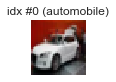

In [17]:
show_image(0, xs, ys, [1, 1])

## 1.1. Normalize xs and one-hot encode ys

In [18]:
print(f"xs: mean={xs.mean():>8.4f}, stddev={xs.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs.mean(), xs.std()
X = (xs - mean) / std

print(f"X:  mean={X.mean():>8.4f}, stddev={X.std():>7.4f}")

xs: mean=117.3316, stddev=63.1088
X:  mean=  0.0000, stddev= 1.0000


In [19]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=118.1221, stddev=63.2348
X_val:  mean=  0.0125, stddev= 1.0020


In [20]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [21]:
Y = onehot_encode(ys)
print(ys.shape, Y.shape)

(80000,) (80000, 10)


In [22]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(10000,) (10000, 10)


## 1.2 Add helper functions for running Computational Graphs

In [23]:
def plot_history(history, n_epochs, batch_size=None, title_prefix=""):
    plot_title = "" if title_prefix == "" else (title_prefix + "\n")
    plot_title += "Train history ({n_epochs} epochs with α = {learning_rate}".format(
        n_epochs=n_epochs, 
        learning_rate=history['lr'])
    plot_title += ")" if batch_size == None else " and {batch_size} batch size)".format(
        batch_size=batch_size)

    # leave only "loss" and "loss_val" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "loss_val")})
    loss_data.index += 1 # start counting the epochs at 1, not 0

    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss J(θ)")
    plt.show()

    # leave only "acc" and "acc_val" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "acc" or k == "acc_val")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [24]:
def train_computational_graph(computational_graph, X, Y, X_val, Y_val, n_epochs, batch_size, verbose=True, plot=True):
    start = time()
    print("Starting to train...")
    computational_graph.train(
        X, Y,
        X_val, Y_val,
        n_epochs,
        batch_size,
        verbose
    )
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    if plot:
        plot_history(computational_graph.history, n_epochs, batch_size, title_prefix=computational_graph.name)
    return computational_graph.history

In [25]:
n_epochs = 24
batch_size = 80

nn_lr = 0.2 #5e-2
regressor_lr = 5e-3

hidden_layer_size = 200

## 2. Perform Multinomial Logistic Regression (i.e. softmax regression)
It is a generalization of Logistic Regression to the case where we want to handle multiple classes

In [26]:
softmax_regressor = ComputationalGraph(
    name="Softmax Regressor",
    cost_function=CrossEntropy(),
    optimizer=GradientDescent(regressor_lr),
    weight_initialization='xavier',
    layers=[
        Layer(IMG_FLAT_SHAPE[0], None, name="Input"), Layer(CLASS_COUNT, SoftMax(), name="Output")
    ])

In [27]:
print(softmax_regressor)

Softmax Regressor
[name?] Layer (input_size, output_size) params_count
----------------------------------------------------
[Input] Layer_0 (3072, 3072) 0
[Output] Layer_1 (3072, 10) 30730



Starting to train...
epoch (1/24) loss: 1.9708, loss_val: 1.9946 | acc: 0.3125, acc_val: 0.3080 | Δt: 2.91s
epoch (2/24) loss: 1.9163, loss_val: 1.9536 | acc: 0.3314, acc_val: 0.3150 | Δt: 3.18s
epoch (3/24) loss: 1.8920, loss_val: 1.9412 | acc: 0.3337, acc_val: 0.3115 | Δt: 2.88s
epoch (4/24) loss: 1.8604, loss_val: 1.9166 | acc: 0.3482, acc_val: 0.3220 | Δt: 2.89s
epoch (5/24) loss: 1.8638, loss_val: 1.9306 | acc: 0.3460, acc_val: 0.3116 | Δt: 2.80s
epoch (6/24) loss: 1.8440, loss_val: 1.9122 | acc: 0.3562, acc_val: 0.3320 | Δt: 2.78s
epoch (7/24) loss: 1.8383, loss_val: 1.9117 | acc: 0.3569, acc_val: 0.3169 | Δt: 2.79s
epoch (8/24) loss: 1.8288, loss_val: 1.9047 | acc: 0.3577, acc_val: 0.3215 | Δt: 2.78s
epoch (9/24) loss: 1.8399, loss_val: 1.9226 | acc: 0.3558, acc_val: 0.3187 | Δt: 2.79s
epoch (10/24) loss: 1.8221, loss_val: 1.9095 | acc: 0.3640, acc_val: 0.3261 | Δt: 2.78s
epoch (11/24) loss: 1.8172, loss_val: 1.9063 | acc: 0.3626, acc_val: 0.3199 | Δt: 2.78s
epoch (12/24) loss: 

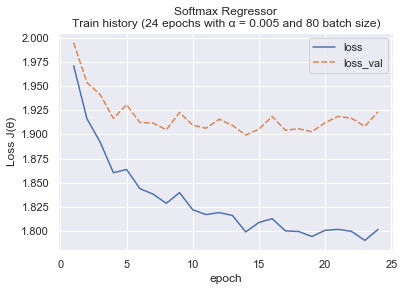

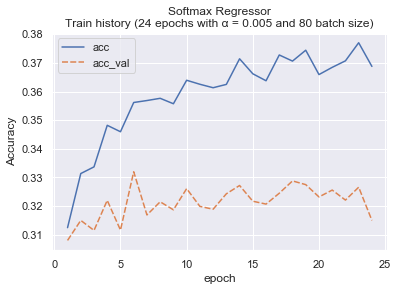

In [28]:
softmax_regressor_history = train_computational_graph(
    softmax_regressor,
    X=X, X_val=X_val,
    Y=Y, Y_val=Y_val,
    n_epochs=n_epochs,
    batch_size=batch_size
)

## 3.  Move on to Neural Networks, using one or two hidden layers

Being $m$ the number of samples in a batch, from a layer $k-1$ to a layer $k$ we have:
- Weights $\mathbb{W}^{(k)} \in \mathbb{R}^{n_{k-1} \times n_k}$
- Biases $\mathbf{b}^{(k)} \in \mathbb{R}^{n_k}$
- Activations $\mathbb{A}^{(k)} = g_k(\mathbb{Z}^{(k)}) \in \mathbb{R}^{m \times n_k}$, where $g_k(\mathbb{Z}^{(k)})$ is the activation function of the $k^{\text{th}}$ layer and $\mathbb{Z}^{(k)} = \mathbb{A}^{(k-1)} \mathbb{W}^{(k)} + \mathbf{b}^{(k)}$

(Xavier initialization: [[1]](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/))

For the first layer, the activation is the input itself: $\mathbb{A}^{(1)} = \mathbb{X} \in \mathbb{R}^{m \times n_1}$, where $n_1$ is the input size (3072)  
For the middle layers ($2 \leq k < L$), the activation function is the sigmoid: $\mathbb{A}^{(k)} = g_k(\mathbb{Z}^{(k)}) = sigmoid(\mathbb{Z}^{(k)})$  
For the last layer, we have the predicted value with softmax activation: $\mathbb{A}^{(L)} = g_k(\mathbb{Z}^{(L)}) = softmax(\mathbb{Z}^{(L)}) \in \mathbb{R}^{m \times n_L}$, where $n_L$ is the output size (10)  
(i.e. the hypothesis function $a^{(L)} = h_{W, b}(x) = y_{\text{pred}} \approx y$)

obs.: the number of layers $L$ comes from: $1$ input layer + $1$ output layer + $L-2$ hidden layers

In [29]:
nn = ComputationalGraph(
    name="Neural Network",
    cost_function=CrossEntropy(),
    optimizer=GradientDescent(nn_lr),
    weight_initialization='xavier',
    layers=[
        Layer(IMG_FLAT_SHAPE[0], None, name="Input"), 
        Layer(hidden_layer_size, Sigmoid(), name="Hidden"), 
        Layer(CLASS_COUNT, SoftMax(), name="Output")
    ])

In [30]:
print(nn)

Neural Network
[name?] Layer (input_size, output_size) params_count
----------------------------------------------------
[Input] Layer_0 (3072, 3072) 0
[Hidden] Layer_1 (3072, 200) 614600
[Output] Layer_2 (200, 10) 2010



Starting to train...
epoch (1/24) loss: 1.7798, loss_val: 1.8211 | acc: 0.3590, acc_val: 0.3434 | Δt: 12.61s
epoch (2/24) loss: 1.6638, loss_val: 1.7353 | acc: 0.4018, acc_val: 0.3805 | Δt: 13.02s
epoch (3/24) loss: 1.6226, loss_val: 1.7429 | acc: 0.4163, acc_val: 0.3801 | Δt: 12.81s
epoch (4/24) loss: 1.5612, loss_val: 1.7338 | acc: 0.4436, acc_val: 0.3833 | Δt: 12.76s
epoch (5/24) loss: 1.4839, loss_val: 1.6950 | acc: 0.4772, acc_val: 0.4015 | Δt: 12.78s
epoch (6/24) loss: 1.4596, loss_val: 1.7184 | acc: 0.4799, acc_val: 0.3871 | Δt: 12.79s
epoch (7/24) loss: 1.4061, loss_val: 1.7062 | acc: 0.5021, acc_val: 0.3952 | Δt: 12.80s
epoch (8/24) loss: 1.3726, loss_val: 1.7193 | acc: 0.5173, acc_val: 0.4028 | Δt: 12.80s
epoch (9/24) loss: 1.3530, loss_val: 1.7554 | acc: 0.5202, acc_val: 0.3948 | Δt: 12.76s
epoch (10/24) loss: 1.3303, loss_val: 1.7742 | acc: 0.5281, acc_val: 0.3892 | Δt: 12.79s
epoch (11/24) loss: 1.2852, loss_val: 1.7820 | acc: 0.5497, acc_val: 0.3891 | Δt: 12.79s
epoch (12

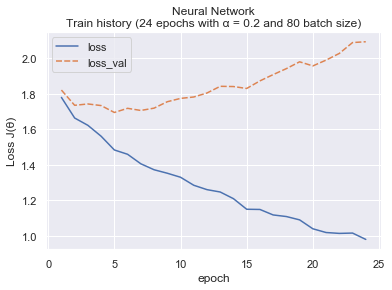

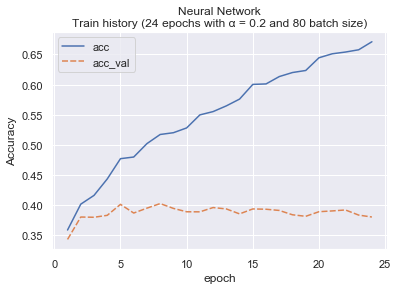

In [31]:
nn_history = train_computational_graph(
    nn,
    X=X, X_val=X_val,
    Y=Y, Y_val=Y_val,
    n_epochs=n_epochs,
    batch_size=batch_size
)

## 4. Compare results with Keras

In [32]:
import tensorflow as tf
from tensorflow import keras

In [33]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam

#callbacks to be used during training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [34]:
keras.__version__

'2.2.4-tf'

In [35]:
def plot_keras_history(history, n_epochs, learning_rate, batch_size=None, title_prefix=""):
    plot_title = "Keras' " + ("" if title_prefix == "" else title_prefix) + "\n"
    plot_title += "Train history ({n_epochs} epochs with α = {learning_rate}".format(
        n_epochs=n_epochs, 
        learning_rate=learning_rate)
    plot_title += ")" if batch_size == None else " and {batch_size} batch size)".format(
        batch_size=batch_size)

    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0

    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss J(θ)")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

## 4.1. Compare softmax regressor

In [36]:
__input  = Input(shape=IMG_FLAT_SHAPE)
__output = Dense(CLASS_COUNT, activation='softmax')(__input)

keras_softmax_regressor = Model(inputs=__input, outputs=__output)
keras_softmax_regressor.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=regressor_lr, momentum=0.0),
    metrics=['accuracy']
)

In [37]:
keras_softmax_regressor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [38]:
keras_softmax_regressor_history = keras_softmax_regressor.fit(
            x=X, y=Y,
            validation_data=(X_val, Y_val),
            epochs=n_epochs,
            batch_size=batch_size
          ).history

Train on 80000 samples, validate on 10000 samples
Epoch 1/24
80000/80000 [==============================] - 3s 39us/sample - loss: 2.0399 - accuracy: 0.2769 - val_loss: 1.9717 - val_accuracy: 0.2926
Epoch 2/24
80000/80000 [==============================] - 2s 31us/sample - loss: 1.9369 - accuracy: 0.3122 - val_loss: 1.9433 - val_accuracy: 0.3101
Epoch 3/24
80000/80000 [==============================] - 2s 31us/sample - loss: 1.9060 - accuracy: 0.3253 - val_loss: 1.9210 - val_accuracy: 0.3159
Epoch 4/24
80000/80000 [==============================] - 2s 31us/sample - loss: 1.8879 - accuracy: 0.3320 - val_loss: 1.9097 - val_accuracy: 0.3189
Epoch 5/24
80000/80000 [==============================] - 2s 31us/sample - loss: 1.8769 - accuracy: 0.3369 - val_loss: 1.9053 - val_accuracy: 0.3172
Epoch 6/24
80000/80000 [==============================] - 2s 31us/sample - loss: 1.8669 - accuracy: 0.3425 - val_loss: 1.9177 - val_accuracy: 0.3212
Epoch 7/24
80000/80000 [==============================] 

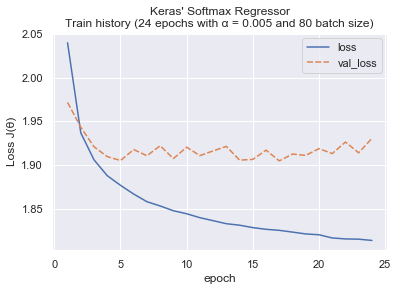

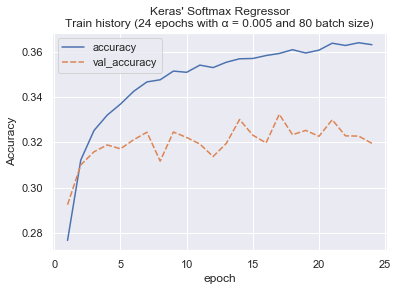

In [39]:
plot_keras_history(keras_softmax_regressor_history, n_epochs, regressor_lr, batch_size, "Softmax Regressor")

## 4.2 Compare neural network

In [40]:
__input  = Input(shape=IMG_FLAT_SHAPE) # 3072
__hidden = Dense(hidden_layer_size, activation='sigmoid')(__input)
__output = Dense(CLASS_COUNT, activation='softmax')(__hidden) # 10

keras_nn = Model(inputs=__input, outputs=__output)
keras_nn.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=nn_lr, momentum=0.0),
    metrics=['accuracy']
)

In [41]:
keras_nn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
Total params: 616,610
Trainable params: 616,610
Non-trainable params: 0
_________________________________________________________________


In [42]:
keras_nn_history = keras_nn.fit(
            x=X, y=Y,
            validation_data=(X_val, Y_val),
            epochs=n_epochs,
            batch_size=batch_size
          ).history

Train on 80000 samples, validate on 10000 samples
Epoch 1/24
80000/80000 [==============================] - 5s 65us/sample - loss: 1.9100 - accuracy: 0.3151 - val_loss: 1.8309 - val_accuracy: 0.3567
Epoch 2/24
80000/80000 [==============================] - 5s 58us/sample - loss: 1.7863 - accuracy: 0.3661 - val_loss: 1.7750 - val_accuracy: 0.3755
Epoch 3/24
80000/80000 [==============================] - 4s 54us/sample - loss: 1.7237 - accuracy: 0.3903 - val_loss: 1.7495 - val_accuracy: 0.3811
Epoch 4/24
80000/80000 [==============================] - 4s 55us/sample - loss: 1.6724 - accuracy: 0.4089 - val_loss: 1.8058 - val_accuracy: 0.3645
Epoch 5/24
80000/80000 [==============================] - 4s 54us/sample - loss: 1.6295 - accuracy: 0.4254 - val_loss: 1.7590 - val_accuracy: 0.3815
Epoch 6/24
80000/80000 [==============================] - 5s 58us/sample - loss: 1.5869 - accuracy: 0.4391 - val_loss: 1.7711 - val_accuracy: 0.3825
Epoch 7/24
80000/80000 [==============================] 

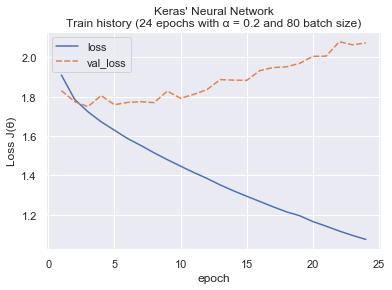

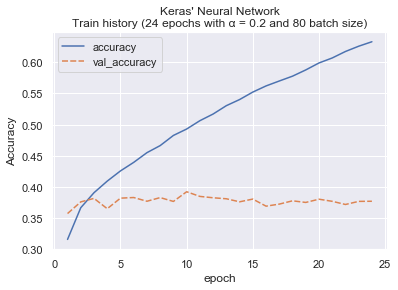

In [43]:
plot_keras_history(keras_nn_history, n_epochs, nn_lr, batch_size, "Neural Network")

## 5. Implement two update rules used to optimize Neural Networks